In [1]:
"""

Bollinger Bands breakout strategy:
- Buy if price closes above the upper band
- Sell if price closes below the lower band

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

def download_data(ticker="BTC-USD", start="2021-01-01", end="2023-01-01"):
    df = yf.download(ticker, start=start, end=end, progress=False)
    
    # Rename for consistency
    df = df.rename(columns={
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Adj Close': 'adj_close',
        'Volume': 'volume'
    })
    
    df.dropna(inplace=True)
    return df

In [2]:
def bollinger_signals(df, window=20, num_std=2):
    # Calculate Bollinger Bands
    df['ma'] = df['close'].rolling(window).mean()
    df['std'] = df['close'].rolling(window).std()
    df['upper_band'] = df['ma'] + num_std * df['std']
    df['lower_band'] = df['ma'] - num_std * df['std']

    # Drop rows with NaN values due to rolling calculations
    df = df.dropna().copy()

    # Initialize signal
    signals = []

    close_vals = df['close'].values
    upper_vals = df['upper_band'].values
    lower_vals = df['lower_band'].values

    for i in range(len(df)):
        if close_vals[i] > upper_vals[i]:
            signals.append(1)
        elif close_vals[i] < lower_vals[i]:
            signals.append(-1)
        else:
            signals.append(0)

    df['signal'] = signals
    return df

In [3]:
def backtest_strategy(df, initial_capital=10000):
    df['returns'] = df['close'].pct_change().fillna(0)
    df['strategy_returns'] = df['signal'].shift(1) * df['returns']
    df['cumulative_market'] = (1 + df['returns']).cumprod()
    df['cumulative_strategy'] = (1 + df['strategy_returns']).cumprod()
    
    final_value = initial_capital * df['cumulative_strategy'].iloc[-1]
    total_return = (final_value - initial_capital) / initial_capital

    drawdown = (
        (df['cumulative_strategy'].cummax() - df['cumulative_strategy']) /
        df['cumulative_strategy'].cummax()
    )
    max_drawdown = drawdown.max()
    
    sharpe_ratio = np.nan
    if df['strategy_returns'].std() != 0:
        sharpe_ratio = (df['strategy_returns'].mean() / df['strategy_returns'].std()) * np.sqrt(252)
    
    result = {
        "Initial Capital": initial_capital,
        "Final Portfolio Value": round(final_value, 2),
        "Total Return": f"{total_return * 100:.2f}%",
        "Max Drawdown": f"{max_drawdown * 100:.2f}%",
        "Sharpe Ratio": round(sharpe_ratio, 2) if not np.isnan(sharpe_ratio) else "N/A"
    }
    
    return df, result

In [4]:
def plot_results(df):
    # Plot price and Bollinger Bands
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(df['close'], label='Price')
    ax.plot(df['ma'], label='MA')
    ax.plot(df['upper_band'], label='Upper Band')
    ax.plot(df['lower_band'], label='Lower Band')
    
    # Plot signals
    buy_signals = df[df['signal'] == 1]
    sell_signals = df[df['signal'] == -1]
    ax.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal')
    ax.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal')
    ax.set_title("Bollinger Bands Breakout - Price & Signals")
    ax.legend()
    plt.show()

    # Equity Curve
    plt.figure(figsize=(14, 6))
    plt.plot(df['cumulative_market'], label='Market Returns')
    plt.plot(df['cumulative_strategy'], label='Strategy Returns')
    plt.title("Bollinger Bands Breakout - Equity Curve")
    plt.legend()
    plt.show()

YF.download() has changed argument auto_adjust default to True
Performance Metrics:
Initial Capital: 10000
Final Portfolio Value: 9189.76
Total Return: -8.10%
Max Drawdown: 34.08%
Sharpe Ratio: -0.01


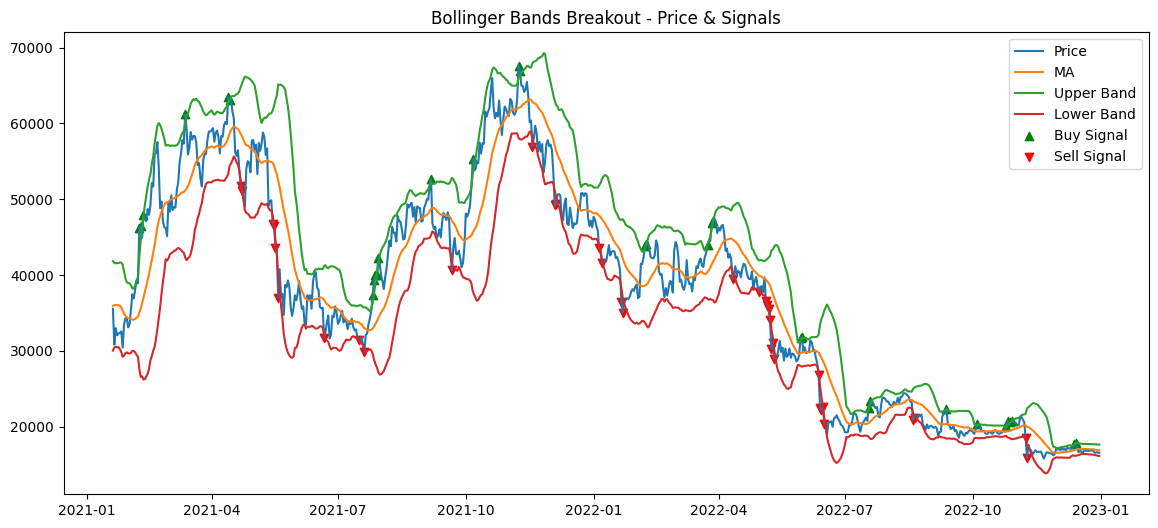

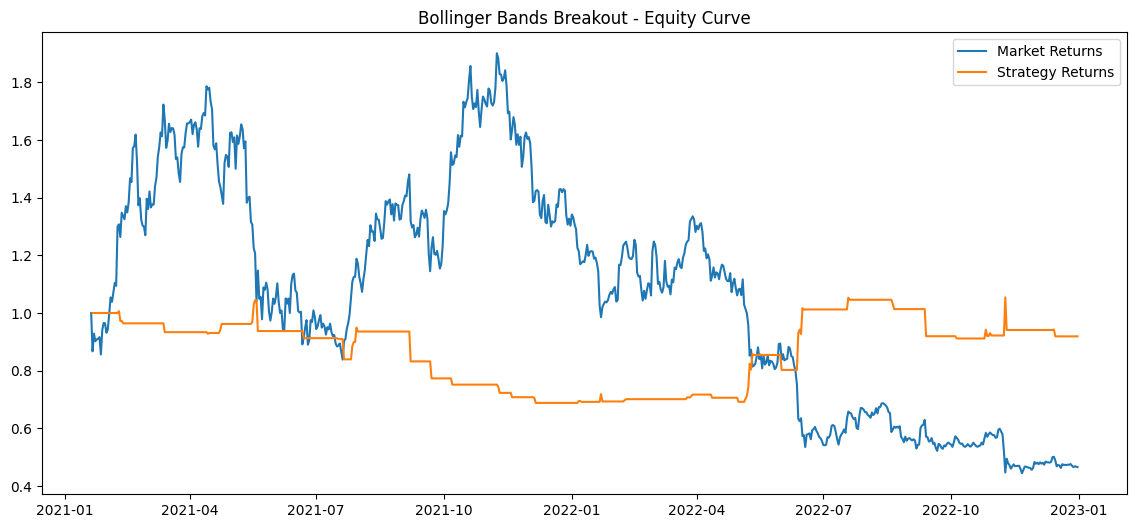

In [5]:
data = download_data("BTC-USD", "2021-01-01", "2023-01-01")
data = bollinger_signals(data, window=20, num_std=2)
data, metrics = backtest_strategy(data, initial_capital=10000)

print("Performance Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

plot_results(data)